# FNC 8.8 — Exercises 2–4 (Python Notebook)

This notebook answers the **programming** exercises from **FNC 8.8 — Preconditioning**.

- Written exercise **1** is answered in `习题解答/na_sol_datahub_8/main.tex`.

We use SciPy's sparse ILU (`spilu`) and GMRES (`scipy.sparse.linalg.gmres`).


In [1]:
# If you're running locally and miss a dependency, uncomment the next line.
# %pip install --index-url https://pypi.org/simple numpy scipy matplotlib

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import tarfile
import time
import urllib.request

from scipy import sparse
from scipy.sparse.linalg import LinearOperator, spilu, gmres
from scipy.io import mmread


## Helpers

In [2]:
ASSET_DIR = Path('numerical-analysis-seminar-datahub/solution/code/ch8/_fnc_assets')
ASSET_DIR.mkdir(parents=True, exist_ok=True)


def ilu_inverse_operator(A: sparse.spmatrix, drop_tol: float, *, fill_factor: float = 10.0) -> LinearOperator:
    ilu = spilu(A.tocsc(), drop_tol=drop_tol, fill_factor=fill_factor)
    return LinearOperator(A.shape, matvec=ilu.solve, dtype=float)


def gmres_with_history(A, b, *, M=None, rtol=1e-4, maxiter=300, restart=None):
    b = np.asarray(b, dtype=float).reshape(-1)
    bnorm = float(np.linalg.norm(b))

    hist = []

    def cb(xk):
        r = b - (A @ xk if not sparse.issparse(A) else A.dot(xk))
        hist.append(float(np.linalg.norm(r)) / bnorm)

    t0 = time.perf_counter()
    x, info = gmres(A, b, M=M, rtol=rtol, atol=0.0, restart=restart, maxiter=maxiter, callback=cb, callback_type='x')
    t = time.perf_counter() - t0

    return x, np.array(hist), info, t


def plot_eigs(ax, lam, title: str):
    ax.scatter(np.real(lam), np.imag(lam), s=6, alpha=0.35)
    ax.axhline(0, color='k', lw=0.5)
    ax.axvline(0, color='k', lw=0.5)
    ax.set_title(title)
    ax.set_xlabel('Re')
    ax.set_ylabel('Im')


def load_rdb2048() -> sparse.csc_matrix:
    # Load SuiteSparse matrix Bai/rdb2048. Downloads once into _fnc_assets.

    mtx_path = ASSET_DIR / 'rdb2048.mtx'
    tar_path = ASSET_DIR / 'rdb2048.tar.gz'

    if not mtx_path.exists():
        if not tar_path.exists():
            url = 'https://suitesparse-collection-website.herokuapp.com/MM/Bai/rdb2048.tar.gz'
            print('Downloading:', url)
            urllib.request.urlretrieve(url, tar_path)

        print('Extracting .mtx from', tar_path)
        with tarfile.open(tar_path, 'r:gz') as tf:
            members = [m for m in tf.getmembers() if m.name.endswith('.mtx')]
            if not members:
                raise FileNotFoundError('No .mtx found inside the downloaded tar.gz')
            member = members[0]
            with tf.extractfile(member) as f:
                mtx_path.write_bytes(f.read())

    A = mmread(mtx_path)
    if not sparse.issparse(A):
        A = sparse.csc_matrix(A)
    else:
        A = A.tocsc()
    return A


## Exercise 2 — ILU eigenvalues: A vs M^{-1}A

Use

\[A = 1.5 I + \mathrm{sprand}(800,800,0.005).\]

For two ILU drop tolerances (τ), plot eigenvalues of A and of M^{-1}A in the complex plane.



τ = 0.3


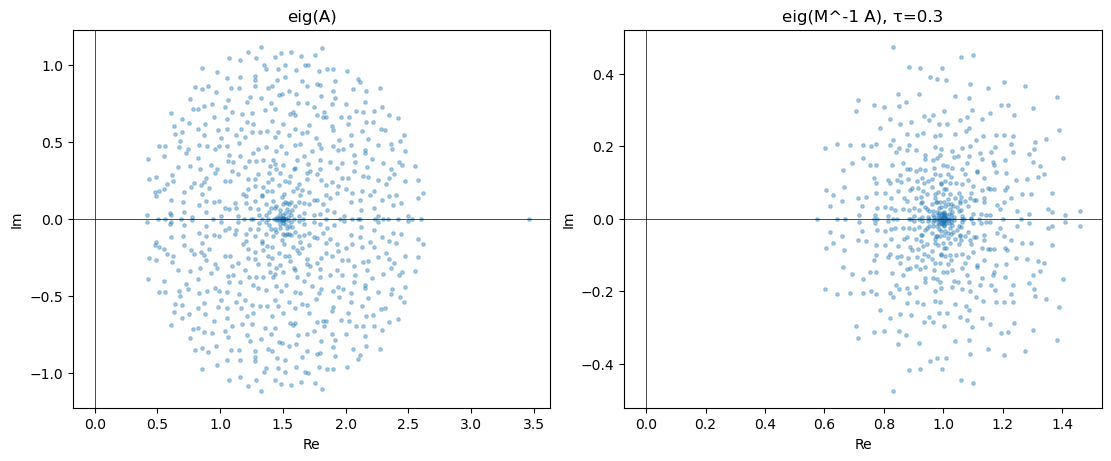

eig(M^-1 A): mean(real) = 1.0004031797950825
eig(M^-1 A): std(real)  = 0.141861706177188

τ = 0.03


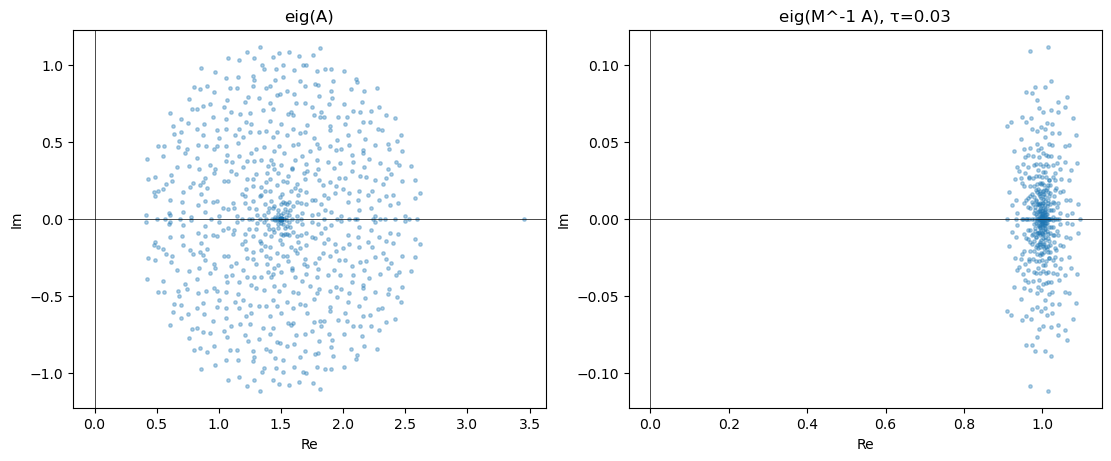

eig(M^-1 A): mean(real) = 1.0000152276597398
eig(M^-1 A): std(real)  = 0.024905520737607746


In [3]:
rng = np.random.default_rng(123)

n = 800
density = 0.005
R = sparse.random(n, n, density=density, format='csc', random_state=rng, data_rvs=rng.random)
A = 1.5 * sparse.identity(n, format='csc') + R

A_dense = A.toarray()
lam_A = np.linalg.eigvals(A_dense)

for tau in [0.3, 0.03]:
    print()
    print('τ =', tau)
    ilu = spilu(A, drop_tol=tau, fill_factor=10.0)

    # Form dense matrix M^{-1}A by applying the ILU solve to each column.
    MinvA = ilu.solve(A_dense)
    lam_MinvA = np.linalg.eigvals(MinvA)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5), constrained_layout=True)
    plot_eigs(axes[0], lam_A, 'eig(A)')
    plot_eigs(axes[1], lam_MinvA, f'eig(M^-1 A), τ={tau}')
    plt.show()

    print('eig(M^-1 A): mean(real) =', float(np.mean(np.real(lam_MinvA))))
    print('eig(M^-1 A): std(real)  =', float(np.std(np.real(lam_MinvA))))


## Exercise 3 — Diagonal preconditioning for a difficult GMRES example

Let

- B = diag(1:100), I = I(100), Z = 0,
- A = [[B, I],[Z, -B]], b = ones(200).

(a) Find a diagonal M with entries ±1 such that M^{-1}A has all positive eigenvalues. Run preconditioned GMRES.

(b) Find a diagonal M such that all eigenvalues of M^{-1}A are 1. Run preconditioned GMRES and report iterations.


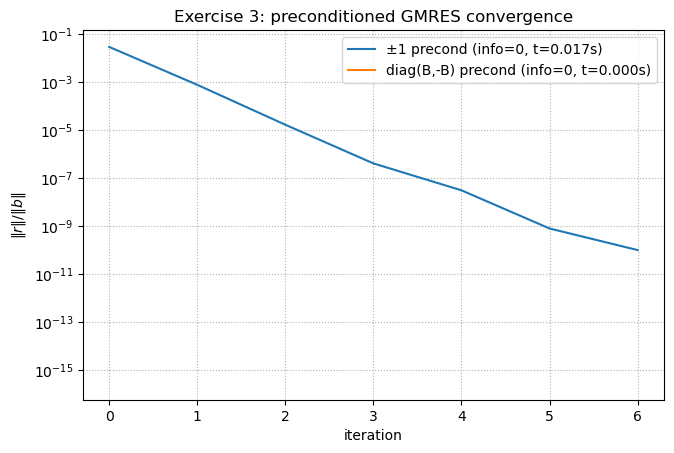

Final relres (±1 precond) = 9.952851871704643e-11
Final relres (diag(B,-B) precond) = 2.8919125489037756e-16


In [4]:
B = np.diag(np.arange(1.0, 101.0))
I = np.eye(100)
Z = np.zeros((100, 100))
A = np.block([[B, I], [Z, -B]])
b = np.ones(200)

# (a) M = diag(I, -I)  -> M^{-1}=M
s = np.ones(200)
s[100:] = -1.0
Minv1 = LinearOperator((200, 200), matvec=lambda x: s * x, dtype=float)

_, hist1, info1, t1 = gmres_with_history(A, b, M=Minv1, rtol=1e-10, maxiter=100, restart=None)

# (b) M = diag(B, -B) so that M^{-1}A = [[I, B^{-1}],[0,I]] has all eigenvalues 1
m_diag = np.concatenate([np.arange(1.0, 101.0), -np.arange(1.0, 101.0)])
Minv2 = LinearOperator((200, 200), matvec=lambda x: x / m_diag, dtype=float)

_, hist2, info2, t2 = gmres_with_history(A, b, M=Minv2, rtol=1e-10, maxiter=100, restart=None)

plt.figure(figsize=(7.5, 4.8))
plt.semilogy(hist1, label=f'±1 precond (info={info1}, t={t1:.3f}s)')
plt.semilogy(hist2, label=f'diag(B,-B) precond (info={info2}, t={t2:.3f}s)')
plt.grid(True, which='both', ls=':')
plt.xlabel('iteration')
plt.ylabel(r'$\|r\|/\|b\|$')
plt.title('Exercise 3: preconditioned GMRES convergence')
plt.legend()
plt.show()

print('Final relres (±1 precond) =', hist1[-1] if hist1.size else None)
print('Final relres (diag(B,-B) precond) =', hist2[-1] if hist2.size else None)


## Exercise 4 — Preconditioning on Bai/rdb2048

Let A be `matrixdepot("Bai/rdb2048")` and b be a vector of 2048 ones.

Use GMRES for up to 300 iterations (no restart) with stopping tolerance 1e-4.

(a) Time GMRES without preconditioning.

(b) Show diagonal preconditioning is not helpful.

(c) Find (to two digits) a drop tolerance τ for ILU at which the method transitions from effective/faster to ineffective.


In [5]:
A = load_rdb2048()
print('A shape:', A.shape, 'nnz:', A.nnz, 'density:', A.nnz / (A.shape[0] * A.shape[1]))

b = np.ones(A.shape[0])

# (a) no preconditioning
_, hist0, info0, t0 = gmres_with_history(A, b, M=None, rtol=1e-4, maxiter=300, restart=None)
print('\n(a) no preconditioning: info=', info0, 'iters=', len(hist0), 'time=', f'{t0:.3f}s', 'final relres=', hist0[-1] if hist0.size else None)

# (b) diagonal preconditioning (M^{-1} = diag(1/diag(A)))
diagA = A.diagonal()
if np.any(diagA == 0):
    print('Warning: zero on diagonal; diagonal preconditioner not defined everywhere.')
    diagA = np.where(diagA == 0, 1.0, diagA)

MinvD = LinearOperator(A.shape, matvec=lambda x: x / diagA, dtype=float)
_, histD, infoD, tD = gmres_with_history(A, b, M=MinvD, rtol=1e-4, maxiter=300, restart=None)
print('(b) diagonal preconditioning: info=', infoD, 'iters=', len(histD), 'time=', f'{tD:.3f}s', 'final relres=', histD[-1] if histD.size else None)

# (c) ILU sweep
candidates = [1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1]
rows = []

for tau in candidates:
    try:
        Minv = ilu_inverse_operator(A, drop_tol=tau, fill_factor=10.0)
        _, hist, info, t = gmres_with_history(A, b, M=Minv, rtol=1e-4, maxiter=300, restart=None)
        rows.append((tau, info, len(hist), t, float(hist[-1]) if hist.size else np.nan))
        print(f'tau={tau: .2g}: info={info}, iters={len(hist)}, time={t:.3f}s, final={hist[-1] if hist.size else None}')
    except Exception as e:
        rows.append((tau, 'FAIL', 0, np.nan, np.nan))
        print(f'tau={tau: .2g}: ILU/GMRES failed:', e)

transition = None
for tau, info, iters, t, final in rows:
    if info != 0:
        transition = tau
        break
    if isinstance(t, float) and t >= t0:
        transition = tau
        break

print('\nBaseline time t0 =', f'{t0:.3f}s')
print('Estimated transition tau (2 digits) ≈', transition)


A shape: (2048, 2048) nnz: 12032 density: 0.00286865234375

(a) no preconditioning: info= 0 iters= 13 time= 0.020s final relres= 9.993689282779836e-05


(b) diagonal preconditioning: info= 300 iters= 300 time= 0.479s final relres= 1.3150325395619518
tau= 0.001: ILU/GMRES failed: Factor is exactly singular
tau= 0.003: ILU/GMRES failed: Factor is exactly singular
tau= 0.01: ILU/GMRES failed: Factor is exactly singular
tau= 0.03: ILU/GMRES failed: Factor is exactly singular


tau= 0.1: info=300, iters=300, time=0.976s, final=29.264775675353565


tau= 0.3: info=300, iters=300, time=0.972s, final=5.890464248014821

Baseline time t0 = 0.020s
Estimated transition tau (2 digits) ≈ 0.001
